# Galaxy Selector MOC

**Compared to the "Simple Galaxy Selector, this works with Multi-Ordering-Sky-Maps**


***NOTE (this note may be wrong, just copied from old notebook)***: Before anything can happen, download the GW event localization map. Open the terminal and type:
"curl -O https://gracedb.ligo.org/api/superevents/sid/files/bayestar.fits,0"
with sid = superevent ID (could be incorporated into this notebook)

Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 99% credible regions for the event, add them as a column to the data
- only keep data within the 99% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc

from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astropy import table

import healpy as hp
import astropy_healpix as ah

from astropy.table import QTable

import psycopg2

from scipy.stats import norm


from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import requests as rq

import gasel as gs

import shutil

In [2]:
# specify the superevent name:
superevent_name = "S230601bf"

In [3]:
path = f"/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/{superevent_name}bayestar.multiorder.fits,1"

try:
    skymap = QTable.read(path)
    print("read skymap from local file")
    
except:
    download_url = f"https://gracedb.ligo.org/api/superevents/{superevent_name}/files/bayestar.multiorder.fits,1"
    save_path = f"Files/{superevent_name}bayestar.multiorder.fits,1"
    print("no local skymap...")
    print(f"...will download LIGO event file from superevent {superevent_name}, corresponding file URL is {download_url} and save it in .../Files/")
    
    response = rq.get(download_url, allow_redirects = True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            #response.raw.decode_content = True
            #shutil.copyfileobj(response.raw, f)
            f.write(response.content)
            
        skymap = QTable.read(path)

no local skymap...
...will download LIGO event file from superevent S230601bf, corresponding file URL is https://gracedb.ligo.org/api/superevents/S230601bf/files/bayestar.multiorder.fits,1 and save it in .../Files/


Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [4]:
skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,2.5600273373541834e-11,824.8069828218769,122.09929120048632,1.4384043694231789e-06
1025,3.475848580528109e-12,854.4827640678935,133.66367778762972,1.3368862907370922e-06
1026,1.0132886671054028e-10,792.1664996083102,114.21108902525555,1.5611049186918174e-06
1027,1.1721535191621473e-11,826.9581632038569,125.47194291890773,1.4293820675925752e-06
1028,3.657353701667604e-13,904.3156663650267,152.3899387240975,1.1890471852797904e-06


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [5]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  360646


In [6]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  112.67578125 22.669609871750385 with prob [1/deg^2] of:  0.0009807661366055865 and UNIQ ID:  360646


Now open the fits file and read basics info from the header

In [7]:
fits_gw = fits.open(path)
header = fits_gw[1].header
dist_mean = header["DISTMEAN"]
dist_std = header["DISTSTD"]
print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)

The dist_mean and dist_std values:  3578.453685813072 Mpc 998.1276979281147 Mpc


In [8]:
most_likely_z = z_at_value(Planck18.luminosity_distance, dist_mean*u.Mpc, zmax = 5)
most_likely_z_std = z_at_value(Planck18.luminosity_distance, dist_std*u.Mpc, zmax = 5)

In [9]:
most_likely_z, most_likely_z_std

(<Quantity 0.59215347 redshift>, <Quantity 0.19748735 redshift>)

In [10]:
# these values (924, 188Mpc) are close to z= 0.19, 0.03

### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [11]:
follow_up_others = False

In [14]:
if follow_up_others:
    center_ra = 235.9839
    center_dec = 15.2248
    radius = 1/360
    z_others = 0
    z_others_std = 0.4
    
    sigma_accuracy = 3
    
    data = gs.db_doall(center_ra, center_dec, radius)
    
    #ii = data["Z"]-sigma_accuracy*data["ZERR"]<z_others+sigma_accuracy*z_others_std
    #ii &= data["Z"]+sigma_accuracy*data["ZERR"]>z_others-sigma_accuracy*z_others_std
    
    #data = data[ii]
    
    
else:
    data = Table.read("/global/homes/j/jgassert/good_z_data.fits")

In [15]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
-407206628,289.160148698913,63.8756777034092,20210513,0.488143245600312,6.00460085329576e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206517,289.24523373072,64.1182126208345,20210513,0.353953432359517,9.16563620937551e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206395,288.991137990503,64.4269390406163,20210513,1.04167986703249,0.000103598417102832,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206306,288.328820102558,64.8171915439228,20210513,0.446085744563991,0.000103302897346752,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206302,288.170414727353,64.8761951861955,20210513,5.11210896599966,0.000690663180059733,0,0.0,0.0,0.0,QSO,0,0.0,0.0


## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of z-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 99% credible region (i.e. with a certainty of 99% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [ ]:
data[:5]

### data clean up

In [ ]:
#data = data[data["Z"]> 0]
#data = data[data["ZWARN"] == 0]

In [16]:
#data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [17]:
data = data[data["TARGETID"]>0]

In [18]:
print(f"We have {len(data)} objects in the full catalog") 

We have 27496796 objects in the full catalog


### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [19]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

distmu = skymap[sorter_i]["DISTMU"]
distsigma = skymap[sorter_i]["DISTSIGMA"]
distnorm = skymap[sorter_i]["DISTNORM"]


In [20]:
# len(UNIQ), len(data), len(skymap)

In [21]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [22]:
data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])

In [23]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
6448025174016,179.15657,28.4234799,20210318,0.0221933367215889,9.68081653157043e-06,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2803,6.027148896496582e-17,inf,1.0,0.0
6521555517440,204.22749,32.09493,20210404,0.3238872170838,2.72909868562699e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,1676,3.109748099951327e-12,617.6918006140204,280.9012674509242,2.1729721937787096e-06
6536638234624,186.274119,32.84503,20210402,0.0764062738003505,1.47657330826664e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2807,9.252387603325823e-15,inf,1.0,0.0
45650485968998,132.7115638,11.7857382,20220130,6.60562456030607e-05,4.43577130671508e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0,1292,2.657973425614709e-13,3095.48035824332,1914.416957030171,7.58422082676225e-08
45650490163336,132.9894508,11.7344802,20220130,0.000113703992211096,4.59116159557144e-06,0,0.0,0.0,0.0,STAR,0,0.0,0.0,1292,2.657973425614709e-13,3095.48035824332,1914.416957030171,7.58422082676225e-08


In [24]:
print(f"The highest and lowest probability values in our catalog are: {np.min(probdensity)} and {np.max(probdensity)}")

The highest and lowest probability values in our catalog are: 5.017377737481738e-23 and 0.000980404482190216


### Sort the skymap table and get 99% credible region

In [25]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [26]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [27]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [28]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
360646,3.2196653011253047,3335.033872366058,928.3289558124724,8.344299628168369e-08
360647,3.21926280635038,3337.8878421184318,931.1690358855824,8.327397239591765e-08
381063,3.2184780597140166,3295.2235223335947,910.7760084338569,8.555785949247677e-08
360596,3.217869486299789,3320.9292770842003,919.8873352187836,8.421230531947861e-08
381074,3.2171488880973067,3290.2851255797577,907.4260565198592,8.584144313973888e-08


In [29]:
# now get 99% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.99
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.99)

# print area
area_99 = pixel_area[:i].sum()
area_99.to_value(u.deg**2)

4609.400699499729

### can be deleted, just tried things out

In [30]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [31]:
np.max(prob)

<Quantity 0.00015583>

In [32]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
360646,3.2196653011253047,3335.033872366058,928.3289558124724,8.344299628168369e-08,5.1446924118210986e-05
360647,3.21926280635038,3337.8878421184318,931.1690358855824,8.327397239591765e-08,5.1440492667669744e-05
381063,3.2184780597140166,3295.2235223335947,910.7760084338569,8.555785949247677e-08,5.1427953227424546e-05
360596,3.217869486299789,3320.9292770842003,919.8873352187836,8.421230531947861e-08,5.141822885320118e-05
381074,3.2171488880973067,3290.2851255797577,907.4260565198592,8.584144313973888e-08,5.140671443863459e-05


In [33]:
skymap_prob = Table(skymap_sort, copy = True)

In [34]:
skymap_prob.sort("PROB", reverse = True)

In [35]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
250435,2.437978345103381,3206.3392640643733,850.803516675709,9.087214947226594e-08,0.00015582549761124234
155301,2.4375633724713546,2997.4666729161177,766.312483674465,1.0447095403943698e-07,0.00015579897427603286
155624,2.4372055395950953,3187.8142069458804,889.4354187719186,9.12971929456903e-08,0.00015577610307780556
94489,2.4371184340562575,3379.4072875167185,988.5413032957259,8.066097320815266e-08,0.00015577053565184323
94239,2.4368942918186134,3464.550021270816,1025.9385663477708,7.65954376653046e-08,0.00015575620940658076


### Compare Tables, only leave 99% credible region in DESI data table

Now we can get a Table that only contains the 99% credible region. From there we only leave the matching objects in the DESI data

In [36]:
# we simply select only the entries that are within the 99% credible region
skymap_99 = skymap_sort[:i]

In [37]:
print("This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_99["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 6128


In [38]:
mask = np.in1d(data["UNIQ"], skymap_99["UNIQ"])
data_99 = data[mask]

In [39]:
print(f"We now have {len(data_99)} objects in the 99% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_99["TARGET_RA"]), np.max(data_99["TARGET_RA"]), np.min(data_99["TARGET_DEC"]), np.max(data_99["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_99["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 1941824 objects in the 99% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  75.9838083028058 281.232040543695 -21.9997270654372 72.3507656527762
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is False


In [40]:
data_99.sort('PROBDENSITY', reverse=True)

In [41]:
data_99[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
39633348737369086,149.526819617568,56.9328774571187,20230111,1.64543104984771,0.000370640678493825,0,7.8147087097168,8.92171192169189,10.6324882507324,QSO,0,0.00702684186398983,0.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08
39633345415482177,149.54492013422,56.8394236579418,20220217,0.26476675533189,4.42247100708578e-05,0,11.9601430892944,32.4653091430664,57.8354148864746,GALAXY,514,0.00669602770358324,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08


In [42]:
print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
min_z = np.min(data_99["Z"])
max_z = np.max(data_99["Z"])
print(f"However, we have not used the distance data at all. Therefore our redhsifts range from {min_z} to {max_z}")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redhsifts range from 5.8544022196563e-10 to 6.87848897451193


### Calculate all the distances of the objects from the redshifts

In [43]:
distances = Distance(z=data_99["Z"], cosmology=Planck18)
distances_err = Distance(z=data_99["ZERR"], cosmology=Planck18)

data_99 = hstack([data_99, Table({"DIST_Z": distances}), Table({"DIST_Z_ERR": distances_err})])

In [44]:
data_99[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
39633348737369086,149.526819617568,56.9328774571187,20230111,1.64543104984771,0.000370640678493825,0,7.8147087097168,8.92171192169189,10.6324882507324,QSO,0,0.00702684186398983,0.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,12540.907632234268,1.642726099829422
39633345415482177,149.54492013422,56.8394236579418,20220217,0.26476675533189,4.42247100708578e-05,0,11.9601430892944,32.4653091430664,57.8354148864746,GALAXY,514,0.00669602770358324,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,1388.8394507498294,0.19596044971073498
39633345415482299,149.561456206428,56.7885091290282,20230111,0.239415745364647,1.12011042538165e-05,0,6.97130107879639,18.6108722686768,35.2831916809082,GALAXY,514,0.00645431550219655,1.40449893474579,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,1238.8816824474231,0.04963102884168046
39633345415482436,149.581908609529,56.7144342394076,20230111,1.46605661338873,8.39649932966265e-05,0,0.512547016143799,0.696299970149994,1.13237380981445,GALAXY,0,0.0074110459536314,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,10882.207319721158,0.3720616608505341
39633345419674766,149.772658447457,56.8675166507996,20220217,0.114034243133952,1.95267095939342e-05,0,77.7299194335938,187.886367797852,338.662719726562,GALAXY,514,0.00805614609271288,4.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,547.6168026494503,0.08652154738189138


### Lets check how much the distance measurement changes in the 99% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our distance ranges from 1075.592223141122 Mpc to 3638.8719547039655 Mpc
Let's visualize the distance distribution of the LIGO event in the 99% credible region


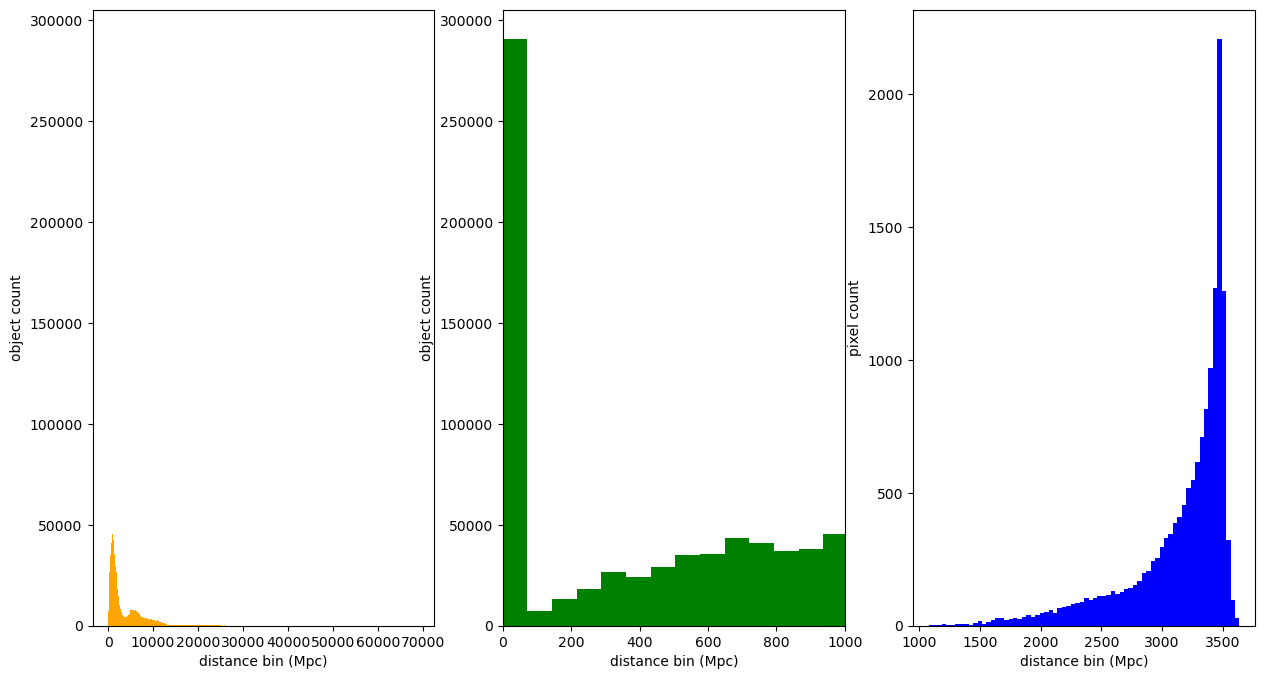

In [45]:
dist_max_99 = np.max(skymap_99["DISTMU"])*u.Mpc
dist_min_99 = np.min(skymap_99["DISTMU"])*u.Mpc
print(f"Our distance ranges from {dist_min_99} to {dist_max_99}")
print("Let's visualize the distance distribution of the LIGO event in the 99% credible region")

fig, ax = plt.subplots(ncols = 3, figsize = (15,8))


ax[0].hist(data_99["DIST_Z"], bins = "auto", color = "orange")
ax[1].hist(data_99["DIST_Z"], bins = "auto", color = "green")
ax[2].hist(skymap_99["DISTMU"], bins = "auto", color = "blue")


for axis in ax:
    axis.set_xlabel("distance bin (Mpc)")

ax[0].set_ylabel("object count")
ax[1].set_ylabel("object count")
ax[2].set_ylabel("pixel count")

ax[1].set_xlim(0,1000)
    
plt.show()

In [46]:
len(skymap_99), len(data_99)

(15197, 1941824)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

*Note: We do this only for our own GW-follow ups*

In [47]:
if follow_up_others == False:
    z_selection_mask = data_99["DIST_Z"] - data_99["DIST_Z_ERR"] <  data_99["DISTMU"] + data_99["DISTSIGMA"]
    z_selection_mask &= data_99["DIST_Z"] + data_99["DIST_Z_ERR"] >  data_99["DISTMU"] - data_99["DISTSIGMA"]

    data_99_z = data_99[z_selection_mask]

    remaining_obj = np.size(np.where(z_selection_mask == True))
    deleted_obj = np.size(np.where(z_selection_mask == False))

    print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
    print(f"Therefore, we have {remaining_obj} objects left in the search region")

    highest_prob_dens = np.max(data_99_z["PROBDENSITY"])
    print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
    print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

    
else:
    data_99_z = data_99
    remaining_obj = len(data_99_z)

The z-range selection has deleted 1718401 objects from originally 1941824 in the data set
Therefore, we have 223423 objects left in the search region
Our highest remaing probability density is 0.000980404482190216 compared to the originally highest prob density of 0.0009807661366055865
The difference in prob density is 3.6165441537057245e-07


In [48]:
data_99_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64
39633348737370580,149.731858864371,56.9312496755096,20220217,0.495489416574863,2.20148581582734e-05,0,2.71986150741577,11.3770246505737,22.8125457763672,GALAXY,265,0.00814501941204071,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2888.1504278588045,0.09754655371973427
39633345419674552,149.746083544443,56.8158924427833,20230111,0.461943734945613,5.90773549384541e-05,0,1.22634875774384,4.27038764953613,12.617564201355,QSO,0,0.00707075512036681,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2656.4599044744687,0.2617757545544275
39633348737370137,149.66794383249,57.0033957865664,20230111,0.451572772372613,1.34600353464372e-05,0,3.38903498649597,8.09316825866699,12.1117086410522,GALAXY,257,0.00760876014828682,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2585.7004374326907,0.05964024119302752
39633348737369876,149.636725167273,56.9238907305412,20230111,0.631628281203086,8.24040065710573e-05,0,0.776683866977692,3.00659418106079,11.125186920166,GALAXY,0,0.00730695435777307,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,3869.3739418810364,0.36514425425509933
39633348737369858,149.634565589934,56.9599748387211,20230111,0.462264229933264,0.000118179614871328,0,1.83348059654236,9.47850799560547,21.6667633056641,GALAXY,257,0.00762270204722881,2.48089051246643,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2658.653228012125,0.523685588637672


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [49]:
# get the apparent mags
data_99_z = data_99_z[data_99_z["FLUX_Z"] > 0] # flux selection (only ones above 0)
data_99_z["MW_TRANSMISSION"] = gs.mw_transmission_from_data_table(data_99_z, "z")
#data_99_z["FLUX_Z"] = data_99_z["FLUX_Z"]/data_99_z["MW_TRANSMISSION"]

app_mag_z = gs.app_mag(data_99_z["FLUX_Z"])
flux_selection_cut = len(data_99_z)
print(f"We have {flux_selection_cut} objects remaining in our catalog, i.e. {remaining_obj-flux_selection_cut} had to be cut out due to bad fluxes")

# get the absolute mags
abs_mag_z = gs.abs_mag(app_mag_z, data_99_z["Z"], 0,0,0)

# get the luminosities
lums_z = gs.lum(abs_mag_z, band = "z")

We have 217703 objects remaining in our catalog, i.e. 5720 had to be cut out due to bad fluxes


In [50]:
data_f = hstack([data_99_z, Table({"APP_MAG_Z": app_mag_z}), Table({"ABS_MAG_Z": abs_mag_z}), Table({"LUM_Z": lums_z})])

In [51]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633348737370580,149.731858864371,56.9312496755096,20220217,0.495489416574863,2.20148581582734e-05,0,2.71986150741577,11.3770246505737,22.8125457763672,GALAXY,265,0.00814501941204071,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2888.1504278588045,0.09754655371973427,0.9910456250627354,19.104565616824246,-23.198533430654813,2.212355876714218e+37
39633345419674552,149.746083544443,56.8158924427833,20230111,0.461943734945613,5.90773549384541e-05,0,1.22634875774384,4.27038764953613,12.617564201355,QSO,0,0.00707075512036681,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2656.4599044744687,0.2617757545544275,0.9922220312120109,19.74756119197147,-22.37395513418315,1.0351985850489562e+37
39633348737370137,149.66794383249,57.0033957865664,20230111,0.451572772372613,1.34600353464372e-05,0,3.38903498649597,8.09316825866699,12.1117086410522,GALAXY,257,0.00760876014828682,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2585.7004374326907,0.05964024119302752,0.991632697810591,19.79198646273774,-22.27090458177483,9.414634163651927e+36
39633348737369876,149.636725167273,56.9238907305412,20230111,0.631628281203086,8.24040065710573e-05,0,0.776683866977692,3.00659418106079,11.125186920166,GALAXY,0,0.00730695435777307,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,3869.3739418810364,0.36514425425509933,0.991963254267453,19.884231708684503,-23.053971804289652,1.936557237942373e+37
39633348737369858,149.634565589934,56.9599748387211,20230111,0.462264229933264,0.000118179614871328,0,1.83348059654236,9.47850799560547,21.6667633056641,GALAXY,257,0.00762270204722881,2.48089051246643,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2658.653228012125,0.523685588637672,0.9916174304385449,19.16051490253551,-22.962793574302935,1.780569974936348e+37


In [52]:
# np.max(data_f["MW_TRANSMISSION"])

In [53]:
max_lum_z = np.max(data_f["LUM_Z"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_Z"] == max_lum_z]["PROBDENSITY"]
print(f"The maximum luminosity in our cataloge in the z-band is {max_lum_z} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our cataloge in the z-band is 4.8209685323601606e+39 W with a prob density of      PROBDENSITY      
----------------------
1.8829814635320415e-05


In [54]:
arg_errfc = abs(data_f["DIST_Z"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2)
P_gal_unnorm = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
#dist_mean*u.Mpc, dist_std*u.Mpc
arg_errfc_c = abs(data_f["DIST_Z"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2)
P_gal_unnorm_const = data_f["LUM_Z"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

# now lets quickly normalize

P_gal_sum = np.sum(P_gal_unnorm)
P_gal_const_sum = np.sum(P_gal_unnorm_const)

P_gal = 1/P_gal_sum * P_gal_unnorm
P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

In [55]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value}), Table({"P_GAL_C": P_gal_const.value})])

In [56]:
data_f[:]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z,DIST_Z_ERR,MW_TRANSMISSION,APP_MAG_Z,ABS_MAG_Z,LUM_Z,P_GAL,P_GAL_C
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,,,,W,,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633348737370580,149.731858864371,56.9312496755096,20220217,0.495489416574863,2.20148581582734e-05,0,2.71986150741577,11.3770246505737,22.8125457763672,GALAXY,265,0.00814501941204071,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2888.1504278588045,0.09754655371973427,0.9910456250627354,19.104565616824246,-23.198533430654813,2.212355876714218e+37,1.8416640967008522e-05,1.8414645957077e-05
39633345419674552,149.746083544443,56.8158924427833,20230111,0.461943734945613,5.90773549384541e-05,0,1.22634875774384,4.27038764953613,12.617564201355,QSO,0,0.00707075512036681,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2656.4599044744687,0.2617757545544275,0.9922220312120109,19.74756119197147,-22.37395513418315,1.0351985850489562e+37,8.614739125971064e-06,8.614260179769438e-06
39633348737370137,149.66794383249,57.0033957865664,20230111,0.451572772372613,1.34600353464372e-05,0,3.38903498649597,8.09316825866699,12.1117086410522,GALAXY,257,0.00760876014828682,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2585.7004374326907,0.05964024119302752,0.991632697810591,19.79198646273774,-22.27090458177483,9.414634163651927e+36,7.833936895427446e-06,7.833627569374711e-06
39633348737369876,149.636725167273,56.9238907305412,20230111,0.631628281203086,8.24040065710573e-05,0,0.776683866977692,3.00659418106079,11.125186920166,GALAXY,0,0.00730695435777307,1.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,3869.3739418810364,0.36514425425509933,0.991963254267453,19.884231708684503,-23.053971804289652,1.936557237942373e+37,1.6117103745117747e-05,1.6126320402089626e-05
39633348737369858,149.634565589934,56.9599748387211,20230111,0.462264229933264,0.000118179614871328,0,1.83348059654236,9.47850799560547,21.6667633056641,GALAXY,257,0.00762270204722881,2.48089051246643,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2658.653228012125,0.523685588637672,0.9916174304385449,19.16051490253551,-22.962793574302935,1.780569974936348e+37,1.4817631959183138e-05,1.4816800757180163e-05
39633345415482130,149.537224366194,56.6595041321063,20230111,0.460513673777709,0.000101019040292401,0,2.99066472053528,15.9578323364258,40.6339836120605,GALAXY,514,0.00828853342682123,6.0,381063,0.000980404482190216,3295.2235223335947,910.7760084338569,8.555785949247677e-08,2646.6780389687087,0.44763658942042706,0.9908885712762286,18.47777649722799,-23.635729071757698,3.309277943651707e+37,2.7538857689442722e-05,2.753738796390736e-05
39633348741563262,149.954222958136,56.9528649591272,20230111,0.459709658429636,8.81255092016979e-05,0,2.23242735862732,12.1529331207275,30.6350231170654,GALAXY,265,0.00874519627541304,4.0,381074,0.00097999959336188,3290.2851255797577,907.4260565198592,8.584144313973888e-08,2641.1819043174432,0.39049878520101156,0.9903889903363263,18.78445446903758,-23.324537096483557,2.484599849812324e+37,2.0667434514318908e-05,2.066635351851813e-05
39633345419675704,149.891817294936,56.8649301601647,20230111,0.46267601975571,9.26238916204923e-05,0,5.85549831390381,21.6097259521484,37.6186370849609,GALAXY,514,0.00898307748138905,2.0,381074,0.00097999959336188,3290.2851255797577,907.4260565198592,8.584144313973888e-08,2661.471913588423,0.4104332809074501,0.9901288523609338,18.561492357238087,-23.564117079961193,3.0980501810962647e+37,2.577096312534408e-05,2.576949088336671e-05


## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}(1-f_{missed})\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}+\sigma_{D,cosmology}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in z-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [91]:
N_galaxies = 2000 # how many galaxies we can cover

In [92]:
total_lum = np.sum(data_f["LUM_Z"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [93]:
data_sort_by_lums = data_f.group_by("LUM_Z")
data_sort_by_lums = data_sort_by_lums[::-1]

In [94]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_Z"][:N_galaxies])

In [95]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 2.1595635615073146e+41, i.e. 4.7954638931054046 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39633368622565352
39628442970359681
39633009653057463
39633352172505887
39633332031457687
39633289681570843
39633383667532068
39633485438125591
39628399743866280
39633191128010265
              ...
39633393213770520
39628255052960067
39633470057611335
39633311382900069
39633387060726555
39633009502060809
39633195343282469
39633478886622792
39628511136188202
39633325194740313
39633450612817977
Length = 2000 rows


### Compare lum with P_Gal ranking

In [96]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_Z"][:N_galaxies])

In [97]:
print(f"The maximum luminosity we cover when ranked by P_gal is {lum_after_N_PGal}, i.e. {lum_after_N_PGal*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal is 1.5266903381024352e+41, i.e. 3.3901240615548853% of the total luminosity
The TARGETID values of these galaxies are: 
    TARGET_RA        TARGET_DEC    ...      TARGETID             P_GAL         
---------------- ---------------- ... ----------------- ----------------------
116.797179528488   26.34502653329 ... 39628399743866280  0.0003363174933252142
166.354676949938 62.7416496256446 ... 39633418954214836  0.0002899761606122327
168.482449448263 63.3291461514701 ... 39633424494887336 0.00027926368297941394
130.185076706171 36.5577312602003 ... 39633009653057463  0.0002450301532173191
132.497954586681 43.2796329743272 ... 39633135171797645  0.0002416392753372487
 141.68120412899 52.9932170192635 ... 39633292965709119 0.00022308268532350166
132.968486045648 45.1116584300074 ... 39633165639223122 0.00021012984383911122
141.763312240856 52.3879326881881 ... 39633285617289303 0.00019891210311610236
152.009857821486 59.5334323094786 ..

In [98]:
data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_Z"][:N_galaxies])

In [99]:
print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])

The maximum luminosity we cover when ranked by P_gal_C is 1.5264985644743479e+41, i.e. 3.3896982146265824% of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID             P_GAL         
----------------- ----------------------
39628399743866280  0.0003363174933252142
39633418954214836  0.0002899761606122327
39633424494887336 0.00027926368297941394
39633009653057463  0.0002450301532173191
39633135171797645  0.0002416392753372487
39633292965709119 0.00022308268532350166
39633165639223122 0.00021012984383911122
39633285617289303 0.00019891210311610236
39633380706356284 0.00018582308051364073
39633443285370161 0.00018491628090662332
              ...                    ...
39632999800636097  3.438535454439531e-05
39633161335866014  3.438576511209034e-05
39628458808054347  3.437453727808431e-05
39633404748106010  3.434067577983272e-05
39633157019928558  3.436498422267833e-05
39633386909730916  3.434885246890853e-05
39633310980246269  3.433995195570268e-05
3963

In [100]:
print(f"These are the stats for {superevent_name} follow up :")

These are the stats for S230601bf follow up :


In [101]:
data_min_z = np.min(data_sort_by_PGal["Z"])
data_max_z = np.max(data_sort_by_PGal["Z"])
data_min_dist = np.min(data_sort_by_PGal["DIST_Z"])
data_max_dist = np.max(data_sort_by_PGal["DIST_Z"])
print(f"Localization area: {area_99.to_value(u.deg**2)*u.deg**2} \nRedshift range in data: {data_min_z} to {data_max_z} \ncorresponding lum distance range: {data_min_dist*u.Mpc} to {data_max_dist*u.Mpc} \nhighest prob location is at RA = {ra.deg*u.deg} and dec = {dec.deg*u.deg} \ntotal No. of objects in desi data is {len(data_sort_by_PGal)}")


Localization area: 4609.400699499729 deg2 
Redshift range in data: 0.144992060610581 to 0.746456673339792 
corresponding lum distance range: 710.1108048993666 Mpc to 4742.475948543975 Mpc 
highest prob location is at RA = 112.67578125 deg and dec = 22.669609871750385 deg 
total No. of objects in desi data is 217703


In [102]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write(f'PGAL/PGAL_{superevent_name}.ecsv', delimiter=',', format='ascii', overwrite = False)

In [103]:
# add timing data to table, 